**1. Descarga y exploración del corpus**


---


Procedemos al estudio del siguiente data set Pet Supplies 5-core, que son reviws de productos para mascotas.

Instalamos las librerías que vamos a usar:

In [ ]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install wordcloud
!pip install gensim

Cargamos el dataset el cúal hemos reducido de 2 millones de registros a 50.000 en local debido a su gran tamaño, ya que este podría impactar en la rapidez del procesamiento y no es el objetivo del proyecto.

In [ ]:
import json
import pandas as pd

file_name = 'Pet_Supplies_5_reducido.json'

# Leemos el archivo
with open(file_name, 'r') as f:
    file_content = f.read()

try:
    data = json.loads(file_content)
    df = pd.DataFrame(data)
    print(df.head())

except json.JSONDecodeError as e:
    print(f"JSONDecodeError: {e.msg}, at line {e.lineno} column {e.colno}")


   overall  verified   reviewTime      reviewerID        asin  \
0      5.0      True  05 27, 2014   AVA8KXONIGNV4  B000FPH1CA   
1      5.0      True  02 16, 2014   A60D5HQFOTSOM  B005GSEC3W   
2      5.0      True  09 22, 2014  A1BBTVAGN6YIGD  B000WFKTWM   
3      1.0     False  08 18, 2017   AS3JM3ZLNJ5DR  B010MVG6ZY   
4      2.0      True  09 25, 2016  A38S15PFJIWRYU  B00JZIDCC6   

                                               style     reviewerName  \
0  {'Flavor Name:': ' Song Plus', 'Pattern:': ' C...  Victoria Puffer   
1  {'Size:': ' 18" L X 13" W X 13" H', 'Color:': ...   DanCooperMedia   
2                           {'Size:': ' 16 lb. Bag'}    ShootingStarz   
3  {'Size:': ' 100-Count Wipes', 'Color:': ' Unsc...        B. Graham   
4  {'Size:': ' 9-Count', 'Flavor Name:': ' Chicke...  Amazon Customer   

                                          reviewText  \
0  This product and actualy be eatten by a human....   
1  I have a Persian cat. He likes sleeping in thi...   
2 

Vemos que el dataframe se ha cargado de forma correcta luego podemos proceder con el siguiente paso, vamos a mirar la cardinalidad del vocabulario.

Número de tokens que componen el vocabulario: 2515103


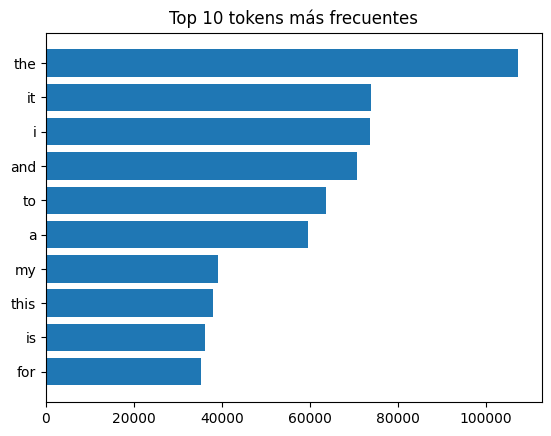

In [ ]:
import re
import matplotlib.pyplot as plt
from collections import Counter

# Unimos todas las reseñas en un solo texto
all_reviews = ' '.join(df['reviewText'].dropna().astype(str))

# Tokenizamos las palabras
words_nltk = re.findall(r'\w+', all_reviews.lower())

# Número de tokens que componen el vocabulario
vocab_size = len(words_nltk)
print(f"Número de tokens que componen el vocabulario: {vocab_size}")

wf = Counter(words_nltk)
wf_most_common = wf.most_common(10)
wf_most_common

words = [w[0] for w in wf_most_common]
freqs = [w[1] for w in wf_most_common]
freqs, words = zip(*sorted(zip(freqs, words)))
plt.barh(words, freqs)
plt.title('Top 10 tokens más frecuentes')
plt.show()

Vemos que las palabras más utilizadas son en su mayoría *stopwords* que no nos aportan información, esto es porque estamos estudiando el texto sin procesar.

Una vez tenemos la cardinalidad del vocabulario pasamos a ver la distribución
por número de estrellas:

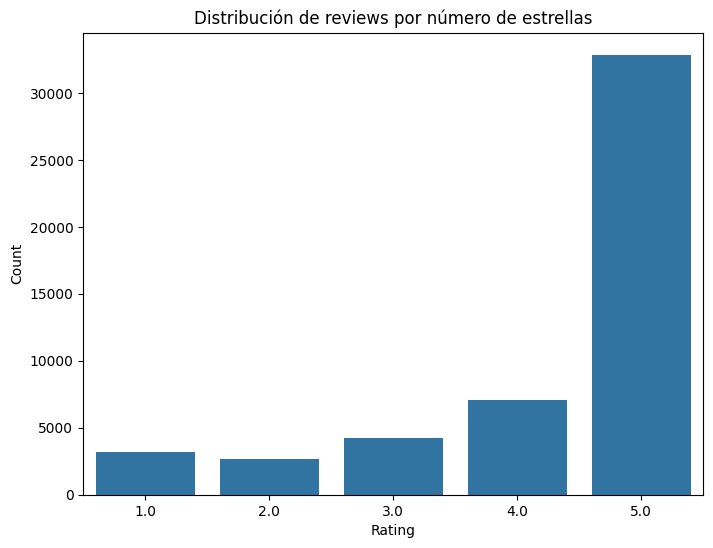

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Representación grafica
plt.figure(figsize=(8, 6))
sns.countplot(x='overall', data=df)
plt.xlabel('Estrellas')
plt.ylabel('Cantidad')
plt.title('Distribución de reviews por número de estrellas')
plt.show()


Vemos que casi todo el mundo puntua los productos entre 4 y 5 estrellas.
Pasamos ahora a ver cuántas son positivas y negativas considerando reviews de 4-5 estrellas como positivas y el resto como negativas.



In [ ]:
positive_reviews = df[df['overall'] >= 4]
negative_reviews = df[df['overall'] < 4]

print(f"Número de reviews positivas: {positive_reviews.shape[0]}")
print(f"Número de reviews negativas: {negative_reviews.shape[0]}")


Número de reviews positivas: 39913
Número de reviews negativas: 10087


La mayoría de las reviews son positivas aparentemente.

Pasamos a mirar los n-grams más frecuentes

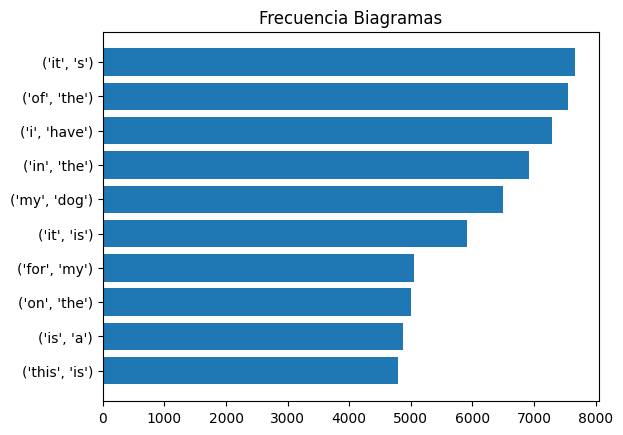

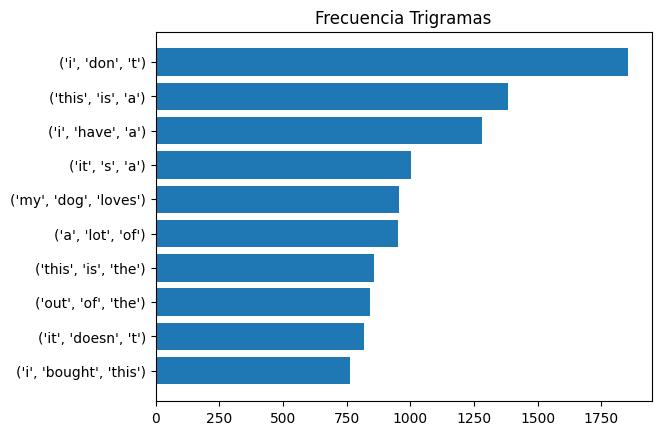

In [ ]:
from nltk import ngrams
from nltk.probability import FreqDist

# Cálculo Bigramas
bigrams_ = list(ngrams(words_nltk, 2))
trigrams_ = list(ngrams(words_nltk, 3))
bg_freq = FreqDist(bigrams_)
tg_freq = FreqDist(trigrams_)
bg_freq.most_common(10)
tg_freq.most_common(10)
bg_freq_most_common = bg_freq.most_common(10)
bgs_ = [str(bg[0]) for bg in bg_freq_most_common]
bgs_f_ = [bg[1] for bg in bg_freq_most_common]

# Cálculo Trigramas
tg_freq_most_common = tg_freq.most_common(10)
tgs_ = [str(tg[0]) for tg in tg_freq_most_common]
tgs_f_ = [tg[1] for tg in tg_freq_most_common]
bgs_f_, bgs_ = zip(*sorted(zip(bgs_f_, bgs_)))
tgs_f_, tgs_ = zip(*sorted(zip(tgs_f_, tgs_)))

# Mostramos
plt.barh(bgs_, bgs_f_)
plt.title('Frecuencia Biagramas')
plt.show()

plt.barh(tgs_, tgs_f_)
plt.title('Frecuencia Trigramas')
plt.show()


Veámos ahora la nube de palabaras:

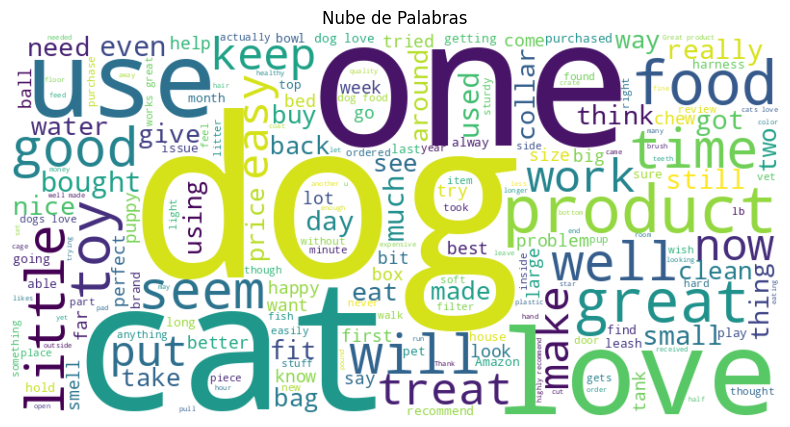

In [ ]:
from wordcloud import WordCloud

# Generar una nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras')
plt.show()


Vemos que palabras como perro, gato, aman, juguetes... Se usan bastante lo cuál tiene sentido teniendo en cuenta el dataset que estamos utilizando. Estas palabras más grandes son las que vamos a utilizar en el siguiente apartado.

Pasamos ahora a la visualización en 2 dimensiones de word embeddings calculados con Word2Vec:

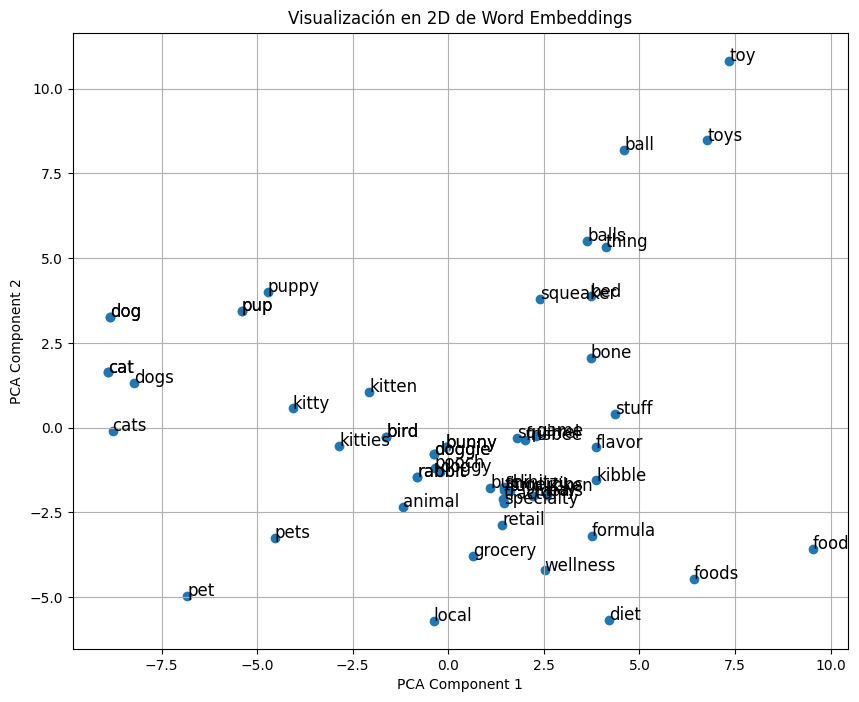

In [ ]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

# Prepararamos los datos para Word2Vec
sentences = [re.findall(r'\w+', review.lower()) for review in df['reviewText'].dropna().astype(str)]

# Entrenamos el modelo Word2Vec con parámetros comunmente utilizados
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Elegimos palabras para visualizar
words = ['dog', 'cat', 'pet', 'food', 'toy']

# Obtenemos los vectores de las palabras
word_vectors = model.wv[words]
top_similar_words = {word: [w for w, _ in model.wv.most_similar(word, topn=10)] for word in words}

# Creamos una lista de todas las palabras a visualizar
all_words = words + [item for sublist in top_similar_words.values() for item in sublist]

# Obtenemos los vectores de todas las palabras
all_word_vectors = model.wv[all_words]

# Reducimos la dimensionalidad a 2D usando PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_word_vectors)

# Creamos un DataFrame para las visualizaciones
pca_df = pd.DataFrame(pca_result, index=all_words, columns=['x', 'y'])

# Visualizamos los embeddings
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['x'], pca_df['y'])

for word, pos in pca_df.iterrows():
    plt.annotate(word, pos, fontsize=12)

plt.title('Visualización en 2D de Word Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()


Vemos que efectivamente el modelo ha sido capaz de poner juntas palabras que tienen relación entre si, como pueden ser dogs-dog, cats-cat, bone-treat, toys-ball... Adeás podemos obsevar que la distribución es arriba a la izquierda perros y gatos y a medida que nos vamos al centro animales de compañía en general. Arriba a la derecha todo lo relacionado con juguetes para perros. Abajo a la izquierda animales de compañía y por último abajo a la izquierda todo lo relacionado con comidas para estos animales.